# CS109 Final Project

## Overview and Motivation

In the U.S., breast cancer is the second most common cancer in women. While breast cancer is often thought of as a single disease, increasing evidence suggests that there are multiple subtypes of breast cancer that occur at different rates in different groups, respond to different kinds of treatment, are more or less aggressive, and have varied long-term survival rates. In addition, risk factors may vary for each different subtypes of breast cancer.  Therefore, it appears that breast cancer outcome is hard to predict. 

The good news is, with the tremendous advancement of high-throughput sequencing technologies, large-scale projects such as the The Cancer Genome Atlas (TCGA) have generated extensive sequencing data libraries of from over 10,000 solid tumors as well as adjacent normal tissue samples across various cancer types. These data not only enable comprehensive characterization of genomic, epigenetic and expression changes in cancers, but sheds new light on cancer subtype classification and even more, cancer diagnostics. 

The goals of our project are to 1. apply machine learning methods to classify breast cancer into several groups and compare their corresponding survival rates based on clinical data. 2. explore potential genetic markers and signatures that can best predict patient outcome. 

## Related Work

At the beginning of our project, we were inspired by the paper "Analysis of breast cancer progression using principal component
analysis (PCA) and clustering" which showed the possibility of using PCA for cancer subtype classfication. However, the number of samples they used was not large enough and there was not convincing validation for their clustering results. That's the main reason why we decided to move forward. During the course of our analysis, we found an comprehensive nature paper "Comprehensive molecular portraits of human breast tumours" that included the useful subtype information. Therefore we could do some supervised analysis based on their discoveries.

##Data Source

Molecular data of breast cancer and clinical data were downloaded from TCGA data portal (https://tcga-data.nci.nih.gov/tcga/) and level-3 mRNA expression data from GDAC firehose website (http://gdac.broadinstitute.org). Note that for breast cancer, whole transcriptome RNA-sequencing (RNA-seq) data was available and we used the RSEM-processed transcript per million (TPM) measure. For more subtype information of the breast cancer, we downloaded the supplementary information from http://www.nature.com/nature/journal/v490/n7418/full/nature11412.html#supplementary-information .

## Unsupervised Learning in Breast Cancer Data

In [1]:
#Import modules and read-in the breast cancer RNA-seq data
import os
import csv
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.cluster.vq import *
from sklearn.cross_validation import train_test_split
from sklearn import linear_model
import statsmodels.api as sm
from statsmodels.formula.api import logit, glm, ols
#K-means cluster
from sklearn.cluster import KMeans
from scipy.cluster.vq import kmeans,vq
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

In [2]:
#read in the breast cancer RNA-seq data
#os.chdir("/Users/W.Jiang/cs109/Final-Project/RNAseq")
#os.chdir("/Users/suqinhou/Dropbox/Courses/Harvard/Stat 121/Data Science Final Project")

In [3]:
f = open("brca.txt","rb")
headers = str(f.next()).strip('[').strip(']').strip("'").replace('"','').split() #Create columns for the table from csv object
f.close()
df=pd.read_csv('brca.txt', sep=' ',names=['index'] + headers,low_memory=False)

In [4]:
brca = df.ix[1:] #Delete the first row (duplicate)
brca = brca[brca['index'].map(lambda x: x[0]) != '?'] # delete those with ? in the gene name
brca['index'] = brca['index'].map(lambda x: x.split('|',1)[0])# strip out the part after '|' in gene ID
brca = brca.set_index(brca['index'])
brca = brca.drop('index',1)

In [5]:
len(brca)

20502

Among the more than 20,000 genes in total, we considered those top 1000 genes with the largest variances in our following analysis. 

In [6]:
#duplicate the brca dataflame for sorting
brca_for_sort = brca
brca_for_sort['var'] = brca_for_sort[headers].values.astype(np.float).var(axis=1) 
#convert strings into floats, then calculate the variance across each row

In [7]:
brca_for_sort.head()

,TCGA-3C-AAAU-01A-11R-A41B-07,TCGA-3C-AALI-01A-11R-A41B-07,TCGA-3C-AALJ-01A-31R-A41B-07,TCGA-3C-AALK-01A-11R-A41B-07,TCGA-4H-AAAK-01A-12R-A41B-07,TCGA-5L-AAT0-01A-12R-A41B-07,TCGA-5L-AAT1-01A-12R-A41B-07,TCGA-5T-A9QA-01A-11R-A41B-07,TCGA-A1-A0SB-01A-11R-A144-07,TCGA-A1-A0SD-01A-11R-A115-07,...,TCGA-UU-A93S-01A-21R-A41B-07,TCGA-V7-A7HQ-01A-11R-A33J-07,TCGA-W8-A86G-01A-21R-A36F-07,TCGA-WT-AB41-01A-11R-A41B-07,TCGA-WT-AB44-01A-11R-A41B-07,TCGA-XX-A899-01A-11R-A36F-07,TCGA-XX-A89A-01A-11R-A36F-07,TCGA-Z7-A8R5-01A-42R-A41B-07,TCGA-Z7-A8R6-01A-11R-A41B-07,var
index,,,,,,,,,,,,,,,,,,,,,
A1BG,1.01881289781952e-05,1.14079985273912e-05,1.99325948087105e-05,8.72411049461146e-06,1.44905852302135e-05,9.71237557369492e-06,9.65074933885455e-06,1.59264077208317e-05,2.2323725422463e-06,8.0162609773865e-06,...,1.13141031197897e-05,3.032188632983e-05,2.3545697019954e-05,3.65594822846963e-06,1.4609724810879e-05,1.15030998873056e-05,1.24684577564409e-05,1.4884298438628e-05,1.215673e-05,1.215380e-10
A1CF,0,0,3.58953580309195e-08,0,1.99323471009639e-08,0,0,2.22791463558643e-08,0,0,...,0,0,1.89631408209442e-08,0,0,0,1.02413793484488e-07,0,0.000000e+00,1.481781e-14
A2BP1,0,0,0,0,1.41735889079037e-07,1.2289968894282e-08,0,2.62648752171274e-08,9.65595689743299e-08,8.01086542803903e-09,...,0,6.5034799328383e-09,1.04926864397151e-07,6.21223622460735e-08,0,9.15069832630146e-09,3.10698114342e-08,8.55916003938755e-09,0.000000e+00,7.831692e-13
A2LD1,6.47474016159085e-06,4.1348151493856e-06,7.80704982137846e-06,3.55063344442918e-06,9.55175021410549e-06,6.26812816742581e-06,4.91162712233055e-06,1.24416243240439e-05,2.20388078986896e-06,4.01040741351564e-06,...,9.03659930587086e-06,4.60868287289633e-06,2.96340215462349e-06,1.17914724850658e-05,2.09905225533371e-06,7.94216016470063e-06,4.81380826483996e-06,3.25342576174833e-06,1.399370e-06,8.162138e-12
A2ML1,3.70184712303817e-08,8.41019598961399e-08,0,3.5349932383371e-08,1.19811479603399e-07,2.8515776354738e-08,8.9120519294382e-08,0,1.00403075674108e-07,1.52136284485427e-07,...,0,2.53110859799124e-07,3.0505690142291e-08,0,9.77784829107319e-08,1.06236434899247e-08,1.19875727204858e-06,3.81709552874463e-08,1.317897e-07,4.305299e-10


In [8]:
brca_for_sort = brca_for_sort.sort('var', ascending=False) #sort the brca by variance from highest to lowest
brca_1000 = brca_for_sort[:1000]
brca_1000.head()

,TCGA-3C-AAAU-01A-11R-A41B-07,TCGA-3C-AALI-01A-11R-A41B-07,TCGA-3C-AALJ-01A-31R-A41B-07,TCGA-3C-AALK-01A-11R-A41B-07,TCGA-4H-AAAK-01A-12R-A41B-07,TCGA-5L-AAT0-01A-12R-A41B-07,TCGA-5L-AAT1-01A-12R-A41B-07,TCGA-5T-A9QA-01A-11R-A41B-07,TCGA-A1-A0SB-01A-11R-A144-07,TCGA-A1-A0SD-01A-11R-A115-07,...,TCGA-UU-A93S-01A-21R-A41B-07,TCGA-V7-A7HQ-01A-11R-A33J-07,TCGA-W8-A86G-01A-21R-A36F-07,TCGA-WT-AB41-01A-11R-A41B-07,TCGA-WT-AB44-01A-11R-A41B-07,TCGA-XX-A899-01A-11R-A36F-07,TCGA-XX-A89A-01A-11R-A36F-07,TCGA-Z7-A8R5-01A-42R-A41B-07,TCGA-Z7-A8R6-01A-11R-A41B-07,var
index,,,,,,,,,,,,,,,,,,,,,
SCGB2A2,0.0186505734368751,0.0178205531441308,0,9.78099787449726e-05,0.00871121218248043,0.00093079497962941,0.00113753353944611,0.0230041265817021,8.69922316690365e-05,0.000327052512734042,...,0.0115141969313085,0.000543484890606968,0.0393304457030222,1.73217586837015e-05,0.00206485983380529,0.00895594012045464,5.55272913213373e-05,0.00673317228892749,0.000052,0.000251
CPB1,0.0055114303871588,1.1262275269895e-06,0.000131441693673882,7.21176473065204e-06,3.89582977111009e-07,1.16548979866682e-05,2.19587814679159e-06,7.95415466856901e-05,6.26875185668725e-06,0.0295681127451367,...,3.25058526333033e-08,1.38374274144522e-06,1.48905411605549e-06,0.000149186801507467,1.01929690533058e-07,5.19866695990234e-07,4.66321369714884e-06,0.000132369013644085,0.000031,0.000101
MGP,0.000276937607783408,0.000121787246191076,0.0011757413002384,0.00694158504976205,0.00747009930169778,0.0113828515763375,0.00394848771084115,0.00382500558435123,0.00927748721515047,0.00260795680087271,...,0.00048674250033613,0.00994588511804627,0.031287251833136,0.0111834092673348,0.000828139711270908,0.00402797263320326,0.00215379800001475,0.0276906405275067,0.004617,0.000083
PIP,0.00201872844877064,6.55255423665201e-05,0,0.000578043633654244,4.28941689510483e-05,5.32784503760792e-05,0.000790555263928412,7.48698081895445e-05,9.67796355388749e-06,0.000906861352032841,...,0.000517480101254298,0.000274269036922022,0.000164484118521302,0.00102497181972606,0.00144021633794695,0.000136701446467891,0.000142479663385302,0.000404825695010722,0.000012,0.000054
SCGB1D2,0.00172617626428221,0.000444781525785907,2.56740518821484e-07,2.60980131248916e-05,0.000213420493811844,0.000178705696820472,0.000178257531770274,0.00163686807696162,7.48760788385168e-05,7.27535071229234e-05,...,0.00152538250288226,0.000169461812114143,0.00346768717469777,1.93597130546418e-06,0.000278859660595134,0.00487708586364221,3.17085734991636e-05,0.00130973550230481,0.000011,0.000053


In [9]:
brca_1000_trans = brca_1000.transpose()
brca_1000_trans = brca_1000_trans[0:1209]    # remove the variance row

## K-Means Clustering

Based on the gene expression profiles of the top 1000 genes with the largest variances, we then did K-means clustering of all the 1209 patients. First, we tried to divide the total samples into 2 clusters, by which we wanted to see whether tumor samples and adjacent normal samples could be divided into two groups.

In [10]:
#from the barcodes of the patients, we first set k=2
cluster2_predict = KMeans(n_clusters=2, init='k-means++', n_init=10, max_iter=10000, tol=0.0001, precompute_distances='auto', 
                          verbose=0, random_state=None, copy_x=True, n_jobs=1).fit_predict(brca_1000_trans, y=None)

In [11]:
cluster2_predict = np.asarray(cluster2_predict.tolist())

In [12]:
#find out the tumor sample VS normal sample
tumor_ind=[]
for i in range(len(brca_1000_trans.index)):
    if brca_1000_trans.index[i][13:15]=="01": #tumor samples
        tumor_ind.append(1)
    elif brca_1000_trans.index[i][13:15]=="11": #adjacent normal samples
        tumor_ind.append(0)
    else:
        tumor_ind.append(1)

In [13]:
#compare the k=2 clustering result with the tumor VS normal classification
count = 0
for i in range(len(tumor_ind)):
    if sum(cluster2_predict)>len(tumor_ind)/2:
        if tumor_ind[i]==cluster2_predict[i]:
            count = count+1
    else:
        if tumor_ind[i]!=cluster2_predict[i]:
            count = count+1
        
accuracy=(count+0.0)/len(tumor_ind)            

In [14]:
accuracy

0.8577336641852771

By comparing the results from K-Means clustering results and actual tumor VS normal classification, the accuracy is pretty high. In that sense, we can trust K-Means clustering for our futher analysis on this dataset. On the other hand, the 15% error might suggest substantial variances within each group.

In [15]:
#transform the dataframe to array with float datatype
brca_array = np.array(brca_1000_trans,dtype=float)

To find the optimal number of clusters, we drew a Elbow curve which shows the change of average within-cluster variances as the k increases. If we find after a specific k, the within-cluster variances drops slowly or keeps the same, we might think this is a nice k.

In [16]:
K = range(1,10)
KM = [kmeans(brca_array,k) for k in K]
centroids = [cent for (cent,var) in KM]   # cluster centroids
avgWithinSS = [var for (cent,var) in KM] # mean within-cluster sum of squares

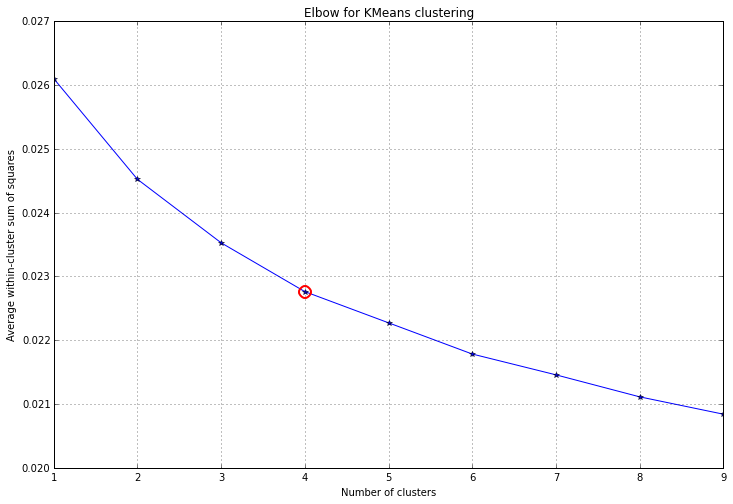

In [17]:
# elbow curve for validation
%matplotlib inline
kIdx = 3
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.plot(K, avgWithinSS, 'b*-')
ax.plot(K[kIdx], avgWithinSS[kIdx], marker='o', markersize=12, 
    markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
plt.title('Elbow for KMeans clustering')
plt.show()

Based on the Elbow curve above, there are most likely 4 clusters in total.                                        However, for now we used the dataset which includes both normal samples and tumor samples.

In [18]:
cluster4_predict = KMeans(n_clusters=4, init='k-means++', n_init=10, max_iter=1000, tol=0.0001, precompute_distances='auto', verbose=0, 
       random_state=None, copy_x=True, n_jobs=1).fit_predict(brca_1000_trans, y=None)

In [19]:
cluster4_predict = np.asarray(cluster4_predict.tolist())

In [20]:
cluster4_predict[1:100]

array([1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 3, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1])

In [21]:
color = []
for i in cluster4_predict:
    if i == 1:
        color.append('green')
    elif i == 2:
        color.append('red')
    elif i == 3:
        color.append('blue')
    else:
        color.append('yellow')

To show the result of K-Means cluster, with k set to 4, we drew a 2-D plot showing the distribution of gene signatures of the top two genes based on their sorted variances, among the 1209 patients. 

/Users/suqinhou/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


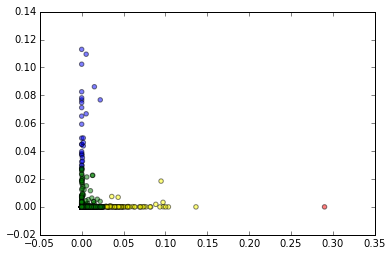

In [22]:
plt.scatter(brca_1000.iloc[0:1,0:1209].values.tolist()[0], brca_1000.iloc[1:2,0:1209].values.tolist()[0], c=color, alpha=0.5)
plt.show()

We also drew a 3-D plot showing the 1209 patients' distribution of their gene expression profiles of the top genes based on their sorted variances.

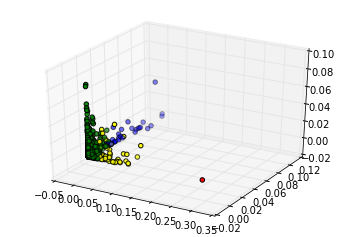

In [23]:
import pylab
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter([float(i) for i in brca_1000.iloc[0:1,0:1209].values.tolist()[0]], 
           [float(i) for i in (brca_1000.iloc[1:2,0:1209].values.tolist()[0])], [float(i) for i in (brca_1000.iloc[2:3,0:1209].values.tolist()[0])],
           c=color)
plt.show()

By far, we did all our analysis based on both normal samples and tumor samples. However, the result shows that the number of three clusters are relatively small compared to the remaining one. We thought the inner variances among the normal samples are higher, which obscured the variances among the tumor samples. So we turn to tumor samples only.

In [24]:
#pick out the tumor sample(remove the normal sample)
brca_tumor = brca_1000_trans[brca_1000_trans.index.map(lambda x: x[13:15]) != '11']
brca_tumor = pd.DataFrame(brca_tumor, dtype='float')

Similar as before, we drew Elbow curve to find the optimal number of clusters in the tumor samples.

In [25]:
tumor_array = np.array(brca_tumor,dtype=float)
K = range(1,10)
KM_tumor = [kmeans(tumor_array,k) for k in K]
centroids_tumor = [cent for (cent,var) in KM_tumor]   
avgWithinSS_tumor = [var for (cent,var) in KM_tumor] 

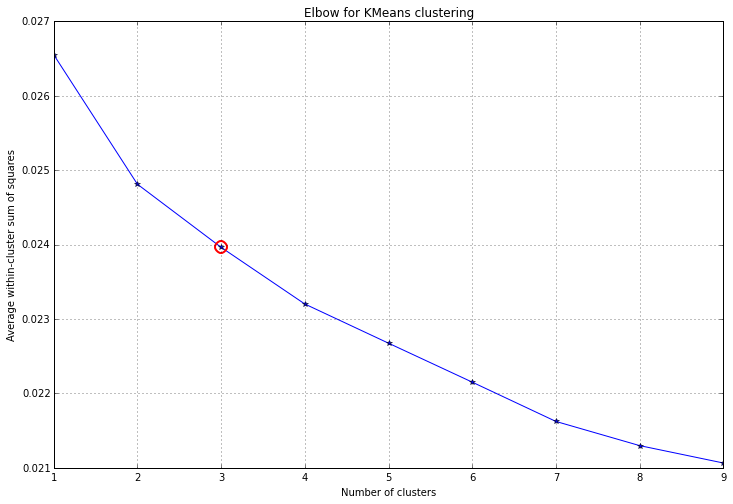

In [26]:
kIdx = 2
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.plot(K, avgWithinSS_tumor, 'b*-')
ax.plot(K[kIdx], avgWithinSS_tumor[kIdx], marker='o', markersize=12, 
    markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
plt.title('Elbow for KMeans clustering')
plt.show()

Based on the Elbow curve above, there are most likely 3 or 4 clusters in total among the 1098 tumor samples.

In [27]:
cluster3_predict = KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=1000, tol=0.0001, precompute_distances='auto', verbose=0, 
       random_state=None, copy_x=True, n_jobs=1).fit_predict(brca_tumor, y=None)

In [28]:
cluster3_predict = np.asarray(cluster3_predict.tolist())

In [29]:
cluster3_predict[1:100]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 2, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1])

## Principle Component Analysis

Since the result of K-Means cluster is not very satisfying, we then turned to Principle Component Analysis, to better visualize different subsets. In addition, we wanted to find the principle components, which we can then include in our prediction models.

In [30]:
#PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
brca_r = pca.fit(brca_tumor).transform(brca_tumor)

In [31]:
brca_pca_trans = brca_r.transpose()
brca_pca_trans

array([[-0.01178205, -0.01070917,  0.00658301, ...,  0.00572922,
        -0.00050498,  0.00641156],
       [-0.00668249,  0.00205161,  0.00176211, ...,  0.00349612,
         0.00530824,  0.00222475],
       [ 0.00621962,  0.00870257,  0.00648739, ...,  0.00392296,
        -0.01913241,  0.00254755]])

In [32]:
color2 = []
for i in cluster3_predict:
    if i == 0:
        color2.append('green')
    elif i == 1:
        color2.append('red')
    else:
        color2.append('blue')


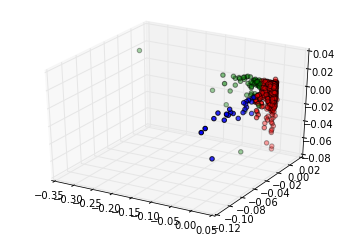

In [33]:
#plot PC1, PC2, PC3
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(brca_pca_trans[0], brca_pca_trans[1], brca_pca_trans[2], c=color2)
plt.show()

In [34]:
brca_tumor_trans = brca_tumor.transpose() # transpose tumor data

In [35]:
# add cluster indicator for each patient to the tumor data
brca_tumor_trans.loc[len(brca_tumor_trans)+1]=cluster3_predict

In [36]:
brca_tumor_trans.head()

,TCGA-3C-AAAU-01A-11R-A41B-07,TCGA-3C-AALI-01A-11R-A41B-07,TCGA-3C-AALJ-01A-31R-A41B-07,TCGA-3C-AALK-01A-11R-A41B-07,TCGA-4H-AAAK-01A-12R-A41B-07,TCGA-5L-AAT0-01A-12R-A41B-07,TCGA-5L-AAT1-01A-12R-A41B-07,TCGA-5T-A9QA-01A-11R-A41B-07,TCGA-A1-A0SB-01A-11R-A144-07,TCGA-A1-A0SD-01A-11R-A115-07,...,TCGA-UL-AAZ6-01A-11R-A41B-07,TCGA-UU-A93S-01A-21R-A41B-07,TCGA-V7-A7HQ-01A-11R-A33J-07,TCGA-W8-A86G-01A-21R-A36F-07,TCGA-WT-AB41-01A-11R-A41B-07,TCGA-WT-AB44-01A-11R-A41B-07,TCGA-XX-A899-01A-11R-A36F-07,TCGA-XX-A89A-01A-11R-A36F-07,TCGA-Z7-A8R5-01A-42R-A41B-07,TCGA-Z7-A8R6-01A-11R-A41B-07
index,,,,,,,,,,,,,,,,,,,,,
SCGB2A2,0.018651,0.017821,0.000000e+00,0.000098,8.711212e-03,0.000931,0.001138,0.023004,0.000087,0.000327,...,0.000003,1.151420e-02,0.000543,0.039330,0.000017,2.064860e-03,8.955940e-03,0.000056,0.006733,0.000052
CPB1,0.005511,0.000001,1.314417e-04,0.000007,3.895830e-07,0.000012,0.000002,0.000080,0.000006,0.029568,...,0.003362,3.250585e-08,0.000001,0.000001,0.000149,1.019297e-07,5.198667e-07,0.000005,0.000132,0.000031
MGP,0.000277,0.000122,1.175741e-03,0.006942,7.470099e-03,0.011383,0.003948,0.003825,0.009277,0.002608,...,0.004471,4.867425e-04,0.009946,0.031287,0.011183,8.281397e-04,4.027973e-03,0.002154,0.027691,0.004617
PIP,0.002019,0.000066,0.000000e+00,0.000578,4.289417e-05,0.000053,0.000791,0.000075,0.000010,0.000907,...,0.003444,5.174801e-04,0.000274,0.000164,0.001025,1.440216e-03,1.367014e-04,0.000142,0.000405,0.000012
SCGB1D2,0.001726,0.000445,2.567405e-07,0.000026,2.134205e-04,0.000179,0.000178,0.001637,0.000075,0.000073,...,0.000006,1.525383e-03,0.000169,0.003468,0.000002,2.788597e-04,4.877086e-03,0.000032,0.001310,0.000011


Based on the PCA result, the 1098 tumor samples have been clearly clustered into 3 subsets. Then we wanted to find differential expressed genes. First, we combined cluster 2 and cluster 3 together and compared gene expression between those in cluster 1 and those in the pooled cluster (cluster 2 and cluster 3 together) via a two-sample t-test with Bonferroni correction. By doing so, we picked out the genes that expressed differentially in cluster 1 compared to those in cluster 2 and cluster 3. We repeated this procedure for the other 2 clusters. In the end, we selected genes included in the intersection of the three sets of differentially expressed genes, that is, we picked out the genes that are differentially expressed in all the 3 clusters of patients.

In [37]:
brca_tumor_for_pca = brca_tumor_trans
brca_tumor_for_pca.loc[len(brca_tumor_for_pca)+1] = brca_pca_trans[0]
brca_tumor_for_pca.loc[len(brca_tumor_for_pca)+1] = brca_pca_trans[1]
brca_tumor_for_pca.loc[len(brca_tumor_for_pca)+1] = brca_pca_trans[2]

In [38]:
index0 = [i for i,x in enumerate(cluster3_predict) if x==0]
index12 = [i for i,x in enumerate(cluster3_predict) if x!=0]
index1 = [i for i,x in enumerate(cluster3_predict) if x==1]
index02 = [i for i,x in enumerate(cluster3_predict) if x!=1]
index2 = [i for i,x in enumerate(cluster3_predict) if x==2]
index01 = [i for i,x in enumerate(cluster3_predict) if x!=2]

In [39]:
group0 = brca_tumor.loc[brca_tumor.index[index0],:]
group1 = brca_tumor.loc[brca_tumor.index[index1],:]
group2 = brca_tumor.loc[brca_tumor.index[index2],:]

In [40]:
group12 = brca_tumor.loc[brca_tumor.index[index12],:]
group02 = brca_tumor.loc[brca_tumor.index[index02],:]
group01 = brca_tumor.loc[brca_tumor.index[index01],:]

In [41]:
z_0 = (brca_tumor.loc[brca_tumor.index[index0],:].mean(axis=0)-brca_tumor.loc[brca_tumor.index[index12],:].mean(axis=0))/np.sqrt(brca_tumor.loc[brca_tumor.index[index0],:].var(axis=0)/len(index0)+brca_tumor.loc[brca_tumor.index[index12],:].var(axis=0)/len(index12))
z_1 = (brca_tumor.loc[brca_tumor.index[index1],:].mean(axis=0)-brca_tumor.loc[brca_tumor.index[index02],:].mean(axis=0))/np.sqrt(brca_tumor.loc[brca_tumor.index[index1],:].var(axis=0)/len(index1)+brca_tumor.loc[brca_tumor.index[index02],:].var(axis=0)/len(index02))
z_2 = (brca_tumor.loc[brca_tumor.index[index2],:].mean(axis=0)-brca_tumor.loc[brca_tumor.index[index01],:].mean(axis=0))/np.sqrt(brca_tumor.loc[brca_tumor.index[index2],:].var(axis=0)/len(index2)+brca_tumor.loc[brca_tumor.index[index01],:].var(axis=0)/len(index01))

In [42]:
from scipy.stats.distributions import norm
zst = -norm.ppf(0.025/len(z_0))

In [43]:
idex_0 = np.flatnonzero(np.abs(z_0) > zst)
idex_1 = np.flatnonzero(np.abs(z_1) > zst)
idex_2 = np.flatnonzero(np.abs(z_2) > zst)

In [44]:
from functools import reduce
deg = reduce(np.intersect1d, (idex_0, idex_1, idex_2))

In [45]:
z_0[deg].index

Index([u'GAPDH', u'S100A7', u'RPL30', u'XBP1', u'KRT14', u'RPS20', u'RPS19',
       u'CRYAB', u'PABPC1', u'RPS2', u'CSTB', u'KRT5', u'RPS27A', u'ENO1',
       u'KRT17', u'TAGLN2', u'MMP7', u'PFN1', u'MT1X', u'RPS7', u'SOD2',
       u'LAPTM4B', u'LOC96610', u'KRT16', u'YBX1', u'MYBPC1', u'STMN1',
       u'FLNA', u'SFRP1', u'UQCRH', u'FBL', u'HDGF', u'SLC25A5', u'NUCB2',
       u'MIA', u'KIAA1324', u'IL32', u'LY6D', u'TUBA1C', u'SH3BGRL3',
       u'MRPL51', u'WARS', u'FUS', u'AKR1C2', u'PHB2', u'COTL1', u'CSDA',
       u'MSN', u'CDK4', u'PDCD5'],
      dtype='object', name=u'index')

In [46]:
brca_tumor_for_pca.tail()

,TCGA-3C-AAAU-01A-11R-A41B-07,TCGA-3C-AALI-01A-11R-A41B-07,TCGA-3C-AALJ-01A-31R-A41B-07,TCGA-3C-AALK-01A-11R-A41B-07,TCGA-4H-AAAK-01A-12R-A41B-07,TCGA-5L-AAT0-01A-12R-A41B-07,TCGA-5L-AAT1-01A-12R-A41B-07,TCGA-5T-A9QA-01A-11R-A41B-07,TCGA-A1-A0SB-01A-11R-A144-07,TCGA-A1-A0SD-01A-11R-A115-07,...,TCGA-UL-AAZ6-01A-11R-A41B-07,TCGA-UU-A93S-01A-21R-A41B-07,TCGA-V7-A7HQ-01A-11R-A33J-07,TCGA-W8-A86G-01A-21R-A36F-07,TCGA-WT-AB41-01A-11R-A41B-07,TCGA-WT-AB44-01A-11R-A41B-07,TCGA-XX-A899-01A-11R-A36F-07,TCGA-XX-A89A-01A-11R-A36F-07,TCGA-Z7-A8R5-01A-42R-A41B-07,TCGA-Z7-A8R6-01A-11R-A41B-07
index,,,,,,,,,,,,,,,,,,,,,
HN1,0.000115,0.000178,0.000421,0.000313,0.000076,0.000068,0.000082,0.000119,0.000044,0.000074,...,0.000199,0.000107,0.000134,0.000043,0.000069,0.000121,0.000074,0.000050,0.000073,0.000223
1001,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1002,-0.011782,-0.010709,0.006583,0.005661,-0.001940,0.005196,0.005378,-0.016001,0.006640,0.006164,...,0.004967,-0.005138,0.005958,-0.032182,0.006834,0.004148,-0.003737,0.005729,-0.000505,0.006412
1003,-0.006682,0.002052,0.001762,0.002561,0.002889,0.003358,0.003499,-0.000533,0.004227,-0.028300,...,-0.000483,0.003607,0.002514,0.003531,0.003603,0.003274,0.002789,0.003496,0.005308,0.002225
1004,0.006220,0.008703,0.006487,0.000396,0.000459,-0.003752,0.003880,0.004368,-0.003639,0.003638,...,0.004877,0.005719,-0.002790,-0.021599,-0.003245,0.004435,0.003374,0.003923,-0.019132,0.002548


## Fitting Regressions
The logistic regression is fitted to model and predict the probability of a subject with breast cancer survived past 1194 (the mean survival time) days adjusting for possible confounders such as the clusters we found above and some genes that are proved in the literatures to be significant predictors of the development of breast cancer. 

We also fitted a Cox Proportional Hazard model to look for important predictors in predicting the hazard ratio over time. Our assumption is that those predictors which are important in the logistic regression above will also be significant in the Cox PH model. 

### Data Preparation

In [47]:
#import clinical data
#os.chdir("/Users/suqinhou/Dropbox/Courses/Harvard/Stat 121/Data Science Final Project/Clinical data")
#os.chdir("/Users/W.Jiang/Dropbox/Data Science Final Project/Clinical data")
clinical = pd.read_csv('Clinical data/clinical_data.csv', sep=',')

We chose 8 possible confounders to be fitted in the logistic regression model and the Cox PH model. They are age, the first Principle Component, PIK3CA (the proved driver gene of breast cancer), TP53 (the gene which being proved to have the most mutations in the genome), metastasis (whether cancer spreaded out from breast to other organs), ENO1 (the most differential expressed gene in tumor samples) and new tumor (whether there is new tumor developed after initial treatment). Here we assume all the missing data are missing at random, hence we dropped all the missing data and fitted the model under complete case analysis.

In [48]:
a = clinical[['sampleID','_TIME_TO_EVENT','vital_status','Age_at_Initial_Pathologic_Diagnosis_nature2012',"HER2_Final_Status_nature2012","Metastasis_Coded_nature2012",'new_tumor_event_after_initial_treatment']].dropna()

In [49]:
a.head()

,sampleID,_TIME_TO_EVENT,vital_status,Age_at_Initial_Pathologic_Diagnosis_nature2012,HER2_Final_Status_nature2012,Metastasis_Coded_nature2012,new_tumor_event_after_initial_treatment
33,TCGA-A2-A0CL-01,1964,LIVING,37,Negative,Negative,NO
36,TCGA-A2-A0CP-01,2813,LIVING,60,Negative,Negative,NO
37,TCGA-A2-A0CQ-01,2695,LIVING,62,Negative,Negative,NO
39,TCGA-A2-A0CS-01,2298,LIVING,73,Negative,Positive,NO
40,TCGA-A2-A0CT-01,2289,LIVING,71,Negative,Negative,NO


In [50]:
a.rename(columns={'Age_at_Initial_Pathologic_Diagnosis_nature2012':'age', 'new_tumor_event_after_initial_treatment':"new_tumor", 'Metastasis_Coded_nature2012': 'metastasis', "HER2_Final_Status_nature2012": "HER2"}, inplace=True)

### Data Visualization

Below is the histogram of age among samples who lived past the median survival and those who deceased before the median survival time.

In [51]:
#Adding indicator variable to the data of whether a patient survived past the mean survival time.
logit_outcome = []
cutoff = np.mean(a._TIME_TO_EVENT)
for i in a['_TIME_TO_EVENT']:
    if i >= cutoff:
        logit_outcome.append(0) # alive past the mean survival time
    else:
        logit_outcome.append(1) # deceased before the mean survival time

a['logit_y'] = logit_outcome

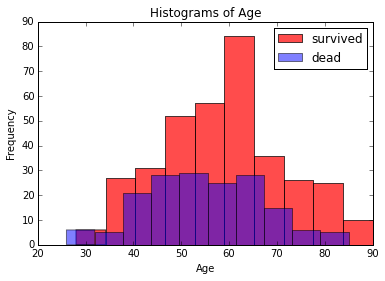

In [52]:
#histograms of age
plt.hist(a[a.logit_y == 1]['age'].tolist(), color='r',alpha=0.7)
plt.hist(a[a.logit_y == 0]['age'].tolist(), alpha=0.5)
plt.title('Histograms of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend(['survived','dead'])
plt.show()

Although the number of people survived after the mean survival time is much greater than the number of poeple deceased before the mean survival time, the distributions of age in two groups are approximately distributed with the same mean around 58, and the variances are very similar as well.

Below are histograms showing the number of new tumor events happends in both groups.

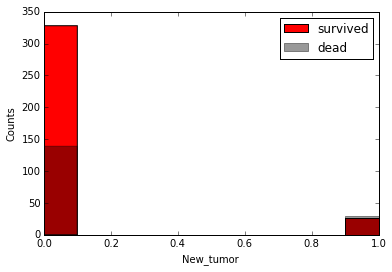

In [53]:
new_tumor = a[a.logit_y == 1]['new_tumor']
new_tumor2 = a[a.logit_y == 0]['new_tumor']
new_tumor_number =[]
new_tumor2_number = []
for i in new_tumor:
    if i == 'NO':
        new_tumor_number.append(0)
    else:
        new_tumor_number.append(1)
        
for i in new_tumor2:
    if i == 'NO':
        new_tumor2_number.append(0)
    else:
        new_tumor2_number.append(1)
        
plt.hist(new_tumor_number, color='r')
plt.hist(new_tumor2_number, alpha=0.4, color='black')
plt.xlabel('New_tumor')
plt.ylabel('Counts')
plt.legend(['survived','dead'])
plt.show()

Both group have around 50 events, but for survived group, the count of samples with no new tumor event after initial treatment is almost 2 times that in the group of samples dead before 1194 days.

Below are histograms showing the number of samples having metastasis and the number of sample didn't have metastasis happends in both groups.

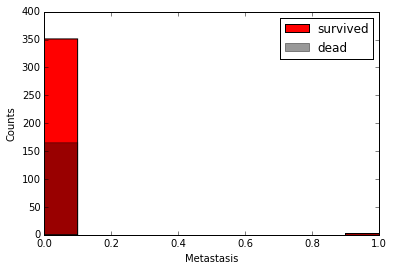

In [54]:
new_tumor = a[a.logit_y == 1]['metastasis']
new_tumor2 = a[a.logit_y == 0]['metastasis']
new_tumor_number =[]
new_tumor2_number = []
for i in new_tumor:
    if i == 'Negative':
        new_tumor_number.append(0)
    else:
        new_tumor_number.append(1)
        
for i in new_tumor2:
    if i == 'Negative':
        new_tumor2_number.append(0)
    else:
        new_tumor2_number.append(1)

plt.hist(new_tumor_number, color='r')
plt.hist(new_tumor2_number, alpha=0.4, color='black')
plt.xlabel('Metastasis')
plt.ylabel('Counts')
plt.legend(['survived','dead'])
plt.show()

In both survived and dead groups there are nearly no samples with metastasis after the initial treatment, hence we decided not to add this variable into the model.

We then appended the cluster indicators calculated from K-means that each patient in the tumor samples belongs to to the clinical data. cluster1 = 1 represents that the patient belongs to the 1st cluster; cluster2 = 1 represents that the patient belongs to the 2nd cluster; and cluster3 = 1 represents that the patient belongs to the 3rd cluster.

In [55]:
brca_trans = brca.transpose()

In [56]:
brca_tumor_for_pca_trans = brca_tumor_for_pca.transpose()

In [57]:
#append cluster indicator and pca1-3 to clinical data
b =[]
c = brca_tumor_for_pca_trans.index.tolist()
d = []
e = []
f = []
g = []
h = []
I = []
J = []
k = []


for i in c:
    i = i[:15]
    d.append(i)

brca_tumor_for_pca_trans['sampleID_sub'] = d

for i in a['sampleID']:
    if i in brca_tumor_for_pca_trans['sampleID_sub'].tolist():
        number = brca_tumor_for_pca_trans['sampleID_sub'].tolist().index(i)
        b.append(brca_tumor_for_pca_trans[1001][number]) # cluster indicator
        e.append(brca_tumor_for_pca_trans[1002][number]) # pca1
        f.append(brca_tumor_for_pca_trans[1003][number]) # pca2
        g.append(brca_tumor_for_pca_trans[1004][number]) # pca3
        h.append(brca_trans['PIK3CA'][number])
        I.append(brca_trans['ENO1'][number])
        J.append(brca_trans['TP53'][number])
        
    else:
        b.append('na')
        e.append('na')
        f.append('na')
        g.append('na')
        h.append('na')
        I.append('na')
        J.append('na')
        
a['cluster_indicator'] = b
a['pca1']=e
a['pca2']=f
a['pca3']=g
a['PIK3CA']=h
a['ENO1']=I
a['TP53']=J

# convert event_observed to boolean
a['event'] = a['vital_status'] == 'DECEASED'

cluster1 = []
cluster2 = []
cluster3 = []
for i in a['cluster_indicator']:
    if i == 0:
        cluster1.append(1)
    else:
        cluster1.append(0)
for i in a['cluster_indicator']:
    if i == 1:
        cluster2.append(1)
    else:
        cluster2.append(0)
for i in a['cluster_indicator']:
    if i == 2:
        cluster3.append(1)
    else:
        cluster3.append(0)
a['cluster1'] = cluster1
a['cluster2'] = cluster2
a['cluster3'] = cluster3

### 1. Logistic Regression

In the logistic regression the outcome is defined as the either dead before the mean survival time of the our sample (1), or alive past the mean survival time (0).

In [58]:
#Adding indicator variable to the data of whether a patient survived past the mean survival time.
logit_outcome = []
cutoff = np.mean(a._TIME_TO_EVENT)
for i in a['_TIME_TO_EVENT']:
    if i >= cutoff:
        logit_outcome.append(0) # alive past the mean survival time
    else:
        logit_outcome.append(1) # deceased before the mean survival time

a['logit_y'] = logit_outcome

In [59]:
# transform the variables into correct data types
a = a[a.pca1 != 'na']
a['pca1_float'] = a.pca1.values.astype(np.float64)
a['TP53_float'] = a.TP53.values.astype(np.float64)
a['PIK3CA_float'] = a.PIK3CA.values.astype(np.float64)
a['cluster_float'] = a.cluster_indicator.values.astype(np.float64)
a['ENO1_float'] = a.ENO1.values.astype(np.float64)

In [60]:
# create dataframes with an intercept column and covariate columns
from patsy import dmatrices
y, X = dmatrices('logit_y ~ age + metastasis + new_tumor + cluster_float + pca1_float + PIK3CA_float + ENO1_float + TP53_float',
                  a, return_type="dataframe")

In [61]:
# Fit logistic model on the entire dataset
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model = model.fit(X, y)
model_logit =logit('logit_y ~ age + metastasis + new_tumor + cluster_float + pca1_float + PIK3CA_float + ENO1_float + TP53_float'
                   , a).fit()
model_logit.summary()

         Current function value: 7.858728
         Iterations: 35


/Users/suqinhou/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/suqinhou/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                logit_y   No. Observations:                  519
Model:                          Logit   Df Residuals:                      510
Method:                           MLE   Df Model:                            8
Date:                Thu, 10 Dec 2015   Pseudo R-squ.:                  -11.51
Time:                        22:47:55   Log-Likelihood:                -4078.7
converged:                      False   LL-Null:                       -326.03
                                        LLR p-value:                     1.000
==========================================================================================
                             coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------
Intercept                 50.5314     10.475      4.824      0.000        30.001    71.062
metastasis[T.Positive]   -19.4584      9.458     -2.057      0.040       -37.997    -0.920
new_tumor[T.YES]         -16.3174      3.696     -4.415      0.000       -23.561    -9.074
age                        0.4237      0.096      4.402      0.000         0.235     0.612
cluster_float            -14.8418      3.341     -4.442      0.000       -21.391    -8.293
pca1_float               200.9353     46.993      4.276      0.000       108.832   293.039
PIK3CA_float           -7.335e+05   1.54e+05     -4.756      0.000     -1.04e+06 -4.31e+05
ENO1_float              1.153e+04   2696.845      4.276      0.000      6246.784  1.68e+04
TP53_float               -6.2e+05   1.27e+05     -4.874      0.000     -8.69e+05 -3.71e+05
==========================================================================================
"""

The summary table above shows that whether developing new tumor after initial treatment, age, cluster, the first Principle Component, PIK3CA, ENO1 and TP53 are important predictors of the log odds of death before 1194 days.

We checked the accuracy of our model on the entire dataset 

In [62]:
# check the accuracy on the entire dataset
model.score(X, y)

0.7032755298651252

Then we splitted the data into training and test data, fitted the same model on the training set and test the statistical power of our model on the test set.

In [63]:
# split data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
model2 = LogisticRegression()
model2.fit(X_train, y_train) # fit logistic model on the training set

/Users/suqinhou/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

In [64]:
# predict indicator labels for the test set
predicted = model2.predict(X_test)

In [65]:
# generate indicator probabilities
probs = model2.predict_proba(X_test)

The accuracy of the model on test set is calculated below.

In [66]:
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
print metrics.accuracy_score(y_test, predicted) # accuracy on test set

0.634615384615


The accuracy is only 63.4%, which is pretty low. However it is pretty reasonable comparing to the accuracy of the model on the entire dataset. Hence one thing remains to do in the future is to do more research on what causes breast cancer, as there seems to be other predictors that haven't been discovered yet.

The confusion matrix of the test dataset is also calculated below.

In [67]:
print metrics.confusion_matrix(y_test, predicted)

[[ 4 49]
 [ 8 95]]


Out of 156 samples, 4 are true positives, 95 are false negatives, 49 are false negatives and 8 are true positives.

### 2. Survival model

### - Kaplan-Meier Curves for each of the 3 clusters

Kaplan-Meier curve is a serious of declining horizontal steps which emulates the true survival functions for the population. Below we plotted 3 Kaplan-Meier curves for each of the three clusters

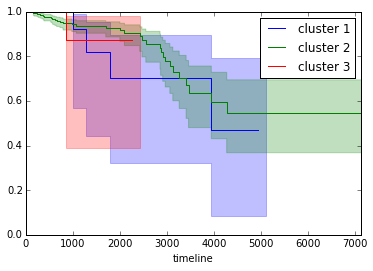

In [68]:
from lifelines import KaplanMeierFitter
sub_0 = a[a.cluster_indicator == 0]
sub_1 = a[a.cluster_indicator == 1]
sub_2 = a[a.cluster_indicator == 2]


%matplotlib inline

kmf = KaplanMeierFitter()
kmf.fit(sub_0._TIME_TO_EVENT, event_observed=sub_0.event, label='cluster 1')
ax1 = kmf.plot()

kmf.fit(sub_1._TIME_TO_EVENT, event_observed=sub_1.event, label='cluster 2')
kmf.plot(ax = ax1)

kmf.fit(sub_2._TIME_TO_EVENT, event_observed=sub_2.event, label='cluster 3')
kmf.plot(ax = ax1)


There is one very short KM-plot which belongs to cluster 3. After examining data in cluster 3, we found that there is only one death and the rest of the observations are all censored. Hence we decided to only use cluster 2 and cluster 3 to fit the logistic regression and Cox Proportional Hazard model below. A new Kaplan-Meier curve is plotted below:

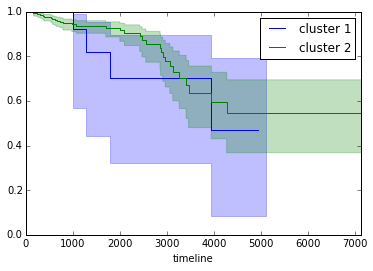

In [70]:
# KM-plot for cluster1 and cluster2
kmf = KaplanMeierFitter()
kmf.fit(sub_0._TIME_TO_EVENT, event_observed=sub_0.event, label='cluster 1')
ax1 = kmf.plot()

kmf.fit(sub_1._TIME_TO_EVENT, event_observed=sub_1.event, label='cluster 2')
kmf.plot(ax = ax1)

The two curves from cluster 1 and cluster 2 are approximately proportional with only a slight cross-over. Hence the proportional hazard assumption is met and we fitted a Cox PH model to estimate the hazard ratio. 

### - Cox Proportional Hazards Model

The Cox PH model gives a semi-parametric method of estimating the hazard function at time t given a baseline hazard that's modified by a set of covariates:

$$\lambda(t|X) = \lambda_0*exp(\beta_0X_0+\beta_1X_1+...+\beta_pX_p)=\lambda_0(t)*exp(\beta X)$$ 

where $\lambda_0(t)$ is the non-parametric baseline hazard function and $\beta X$ is a linear parametric model adjusting for covariates. Here we used age, the first Principle Component, PIK3CA (the proved driver gene of breast cancer), TP53 (the gene which being proved to have the most mutations in the genome), metastasis (whether cancer spreaded out from breast to other organs), ENO1 (the most differential expressed gene in tumor samples) and new tumor (whether there is new tumor developed after initial treatment) as covariates to predict death hazards at each time point.

In [71]:
# code vital_indicator as 1 (dead) or 0 (alive)
vital_indicator = []

for vital in a['vital_status']:
    if vital == 'LIVING':
        vital_indicator.append(0)
    else:
        vital_indicator.append(1)
a['vital_indicator'] = vital_indicator

# get a subset of useful covariates
cox = a[['_TIME_TO_EVENT', 'vital_indicator', 'age','pca1_float','PIK3CA_float','cluster_float','ENO1_float']]

metastasis = []
for meta in a['metastasis']:
    if meta == 'Positive':
        metastasis.append(1)
    else:
        metastasis.append(0)
cox['metastasis'] = metastasis

new_tumor = []
for tumor in a['new_tumor']:
    if tumor == 'NO':
        new_tumor.append(0)
    else:
        new_tumor.append(1)
cox['new_tumor'] = new_tumor


/Users/suqinhou/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/suqinhou/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [72]:
cox.head()

,_TIME_TO_EVENT,vital_indicator,age,pca1_float,PIK3CA_float,cluster_float,ENO1_float,metastasis,new_tumor
33,1964,0,37,0.006365,0.000021,1,0.000822,0,0
36,2813,0,60,0.002934,0.000006,1,0.001034,0,0
37,2695,0,62,0.004700,0.000004,1,0.000739,0,0
39,2298,0,73,0.005222,0.000007,1,0.000494,1,0
40,2289,0,71,0.005956,0.000014,1,0.000503,0,0


We fit the cox model below and print out the summary table.

In [73]:
from lifelines import CoxPHFitter
cf = CoxPHFitter()
cf.fit(cox,'_TIME_TO_EVENT', event_col='vital_indicator')

<lifelines.CoxPHFitter: fitted with 519 observations, 476 censored>

In [74]:
cf.print_summary()

n=519, number of events=43

                    coef  exp(coef)  se(coef)          z         p  lower 0.95  upper 0.95     
age            5.074e-01  1.661e+00 1.757e-01  2.888e+00 3.875e-03   1.630e-01   8.519e-01   **
pca1_float    -1.407e-01  8.687e-01 2.072e-01 -6.791e-01 4.971e-01  -5.470e-01   2.655e-01     
PIK3CA_float   3.634e-01  1.438e+00 1.905e-01  1.908e+00 5.638e-02  -9.962e-03   7.368e-01    .
cluster_float  3.884e-02  1.040e+00 1.957e-01  1.985e-01 8.427e-01  -3.447e-01   4.224e-01     
ENO1_float     1.302e-01  1.139e+00 1.180e-01  1.103e+00 2.699e-01  -1.012e-01   3.617e-01     
metastasis    -4.660e-03  9.954e-01 6.679e-02 -6.978e-02 9.444e-01  -1.356e-01   1.263e-01     
new_tumor      6.642e-01  1.943e+00 1.069e-01  6.212e+00 5.243e-10   4.546e-01   8.739e-01  ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Concordance = 0.809


Apparently age is an important predictor of the death hazard (a unit increase in age is associated with 0.510 increases in log hazard rate). Also, the log hazard rate for those who developed new tumor after initial treatment is 0.6 times that for those who didn't develop new tumor. The PIK3CA (the driver gene of breast cancer) is also proved to be significantly associated with the log hazard ratio. 

## View the baseline Hazard rate and survival rate

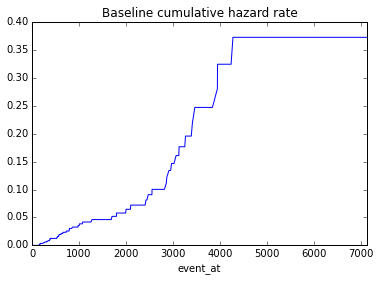

In [75]:
# Hazard rate
cf.baseline_cumulative_hazard_.plot(legend=False
                ,title='Baseline cumulative hazard rate')

As seen above, the hazard rate increases monotonically. Before 3000 days it increases comparably flat, whereas from 3000 days to 4000 days the hazard rate increases dramatically.

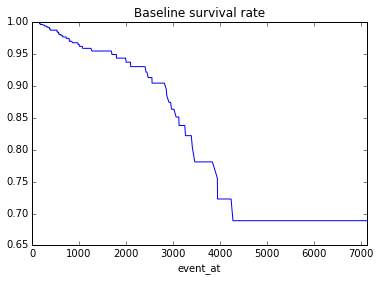

In [76]:
# Survival rate
cf.baseline_survival_.plot(legend=False
                ,title='Baseline survival rate')

## Conclusion

From the Cox regression model, we find that the differential expressed gene PIK3CA (also known as a driver gene of breast cancer) is proved to be significantly associated with the log hazard ratio, so the expression profiles of PIK3CA could be used as a signature to predict patient outcome. We may prove more differential expressed genes that can predict patient outcome in the future. Although principle components are not significantly associated with the log hazard ratio of patients, they are correlated to the patient outcome. We will find other statistical tests to prove that in the future. 